# Plotting COVID-19 Evolution

In [1]:
import pandas as pd

import numpy as np 

import matplotlib.pyplot as plt

import os

## CSSE at Johns Hopkins University Datasets
Reference: https://github.com/CSSEGISandData

### Links

In [2]:
links = {'Notifications': 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
         'Deaths': 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
         'Recupeartions': 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'}

### Preprocessing

In [3]:
df_dict = {}
for link_key in links.keys():
    df = pd.read_csv(links[link_key])
    df.drop(['Province/State', 'Lat', 'Long'], axis = 1, inplace=True)
    df.set_index('Country/Region', inplace=True)
    df = df.T
    df = df.groupby(level=0, axis=1).sum()
    df_dict[link_key] = df

## Chosen Countries

### Population per million
Reference: https://www.worldometers.info/world-population

In [4]:
population_per_million = {'Brazil': 212.374697, 'Italy': 60.472582, 'US': 330.765729,
                          'China': 1438.647008, 'Argentina': 45.145011, 'Sweden': 10.091585}

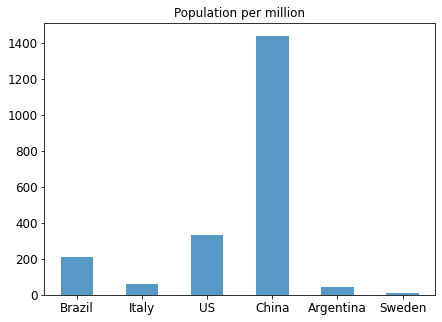

In [5]:
pd.Series(population_per_million).plot(kind='bar', figsize=(7,5), title=f'Population per million', fontsize=12, rot=0, alpha=0.75)

### Area  ($km^2$)  per million
Reference: https://www.google.com

In [6]:
areaKm2_per_million = {'Brazil': 8.516000 , 'Italy': 0.301338, 'US': 9.834000, 
                       'China': 9.597000, 'Argentina': 2.780000, 'Sweden': 0.450295}

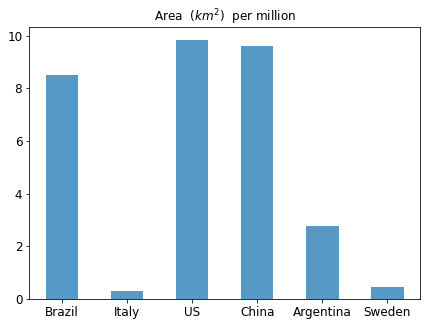

In [7]:
pd.Series(areaKm2_per_million).plot(kind='bar', figsize=(7,5), title=f'Area  ($km^2$)  per million', fontsize=12, rot=0, alpha=0.75)

### Demographic density

In [8]:
density = {key:population_per_million[key]/areaKm2_per_million[key] for key in population_per_million.keys()}
density

{'Brazil': 24.9383157585721,
 'Italy': 200.68023946531804,
 'US': 33.63491244661379,
 'China': 149.90590892987393,
 'Argentina': 16.23921258992806,
 'Sweden': 22.411052754305512}

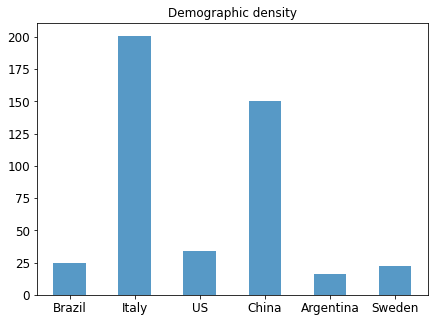

In [9]:
pd.Series(density).plot(kind='bar', figsize=(7,5), title=f'Demographic density', fontsize=12, rot=0, alpha=0.75)

## Plotting normalized datasets by Population Density

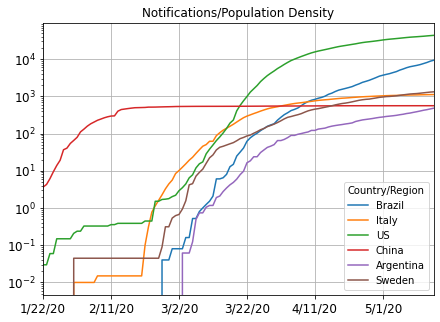

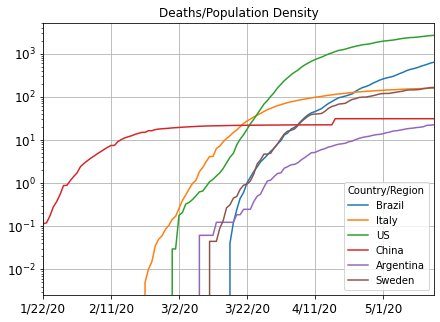

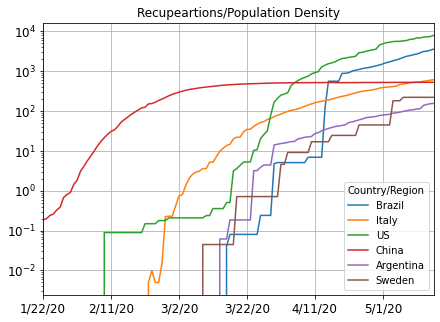

In [10]:
for df_key in df_dict.keys():
    plt.Figure()
    (df_dict[df_key][population_per_million.keys()]/list(density.values())).plot(
                                                        figsize=(7,5), 
                                                        logy=True, 
                                                        title=f'{df_key}/Population Density', 
                                                        grid=True,
                                                        fontsize=12)
    
    try:
        plt.savefig(f'results/{df_key}_normalized_density.png', transparent=True)
    except:
        os.system('mkdir results')
        plt.savefig(f'results/{df_key}_normalized_density.png', transparent=True)
        
    plt.show()

## Plotting normalized datasets by Population per million

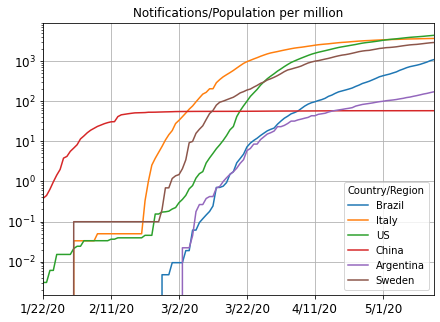

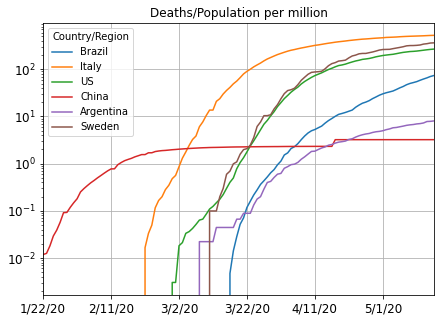

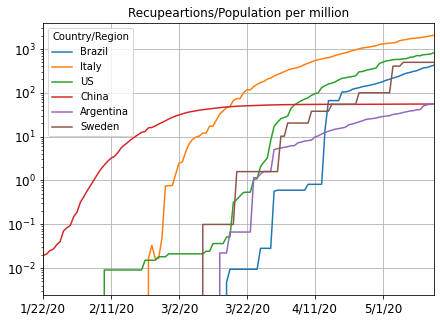

In [11]:
for df_key in df_dict.keys():
    plt.Figure()
    (df_dict[df_key][population_per_million.keys()]/list(population_per_million.values())).plot(
                                                        figsize=(7,5), 
                                                        logy=True, 
                                                        title=f'{df_key}/Population per million', 
                                                        grid=True,
                                                        fontsize=12)
    
    try:
        plt.savefig(f'results/{df_key}_normalized_population.png', transparent=True)
    except:
        os.system('mkdir results')
        plt.savefig(f'results/{df_key}_normalized_population.png', transparent=True)
        
    plt.show()

## Plotting unnormalized datasets

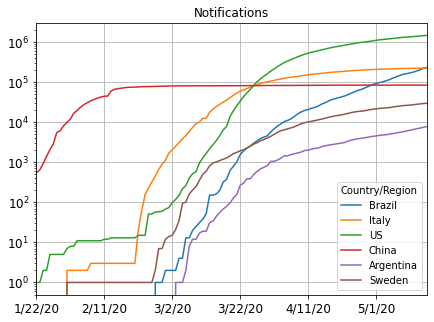

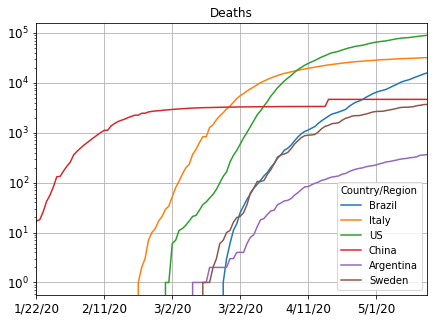

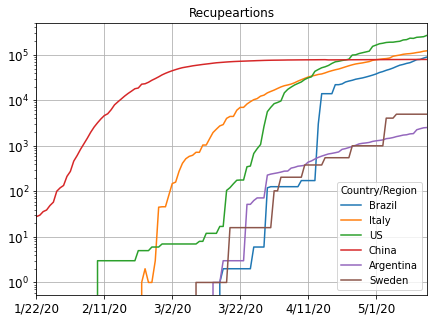

In [12]:
for df_key in df_dict.keys():
    plt.Figure()
    df_dict[df_key][population_per_million.keys()].plot(
                                                        figsize=(7,5), 
                                                        logy=True, 
                                                        title=f'{df_key}', 
                                                        grid=True,
                                                        fontsize=12)
    
    try:
        plt.savefig(f'results/{df_key}.png', transparent=True)
    except:
        os.system('mkdir results')
        plt.savefig(f'results/{df_key}.png', transparent=True)

    plt.show()

## Plotting Death Rate (%)

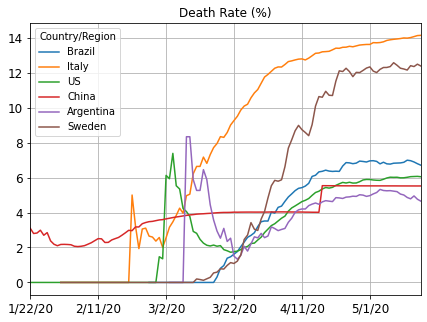

In [13]:
(100*df_dict['Deaths'][population_per_million.keys()]/
 df_dict['Notifications'][population_per_million.keys()]).plot(
                                                                figsize=(7,5), 
                                                                #logy=True, 
                                                                title='Death Rate (%)', 
                                                                grid=True,
                                                                fontsize=12)

try:
    plt.savefig(f'results/death_rate.png', transparent=True)
except:
    os.system('mkdir results')
    plt.savefig(f'results/death_rate.png', transparent=True)
    
plt.show()

# Predicting with Prophet

In [14]:
from fbprophet import Prophet

In [31]:
df_key = 'Notifications'
country = 'US'

df_prophet = pd.DataFrame({'ds': df_dict[df_key].index.values, 'y': df_dict[df_key][country].values})
df_prophet.tail()

,ds,y
111,5/12/20,1369376
112,5/13/20,1390406
113,5/14/20,1417774
114,5/15/20,1442824
115,5/16/20,1467820


In [32]:
m = Prophet()
m.fit(df_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
141,2020-06-11,2.161549e+06,2.074996e+06,2.248052e+06
142,2020-06-12,2.189359e+06,2.097962e+06,2.281120e+06
143,2020-06-13,2.216312e+06,2.121241e+06,2.316066e+06
144,2020-06-14,2.242300e+06,2.141582e+06,2.346301e+06
145,2020-06-15,2.266759e+06,2.162709e+06,2.372930e+06


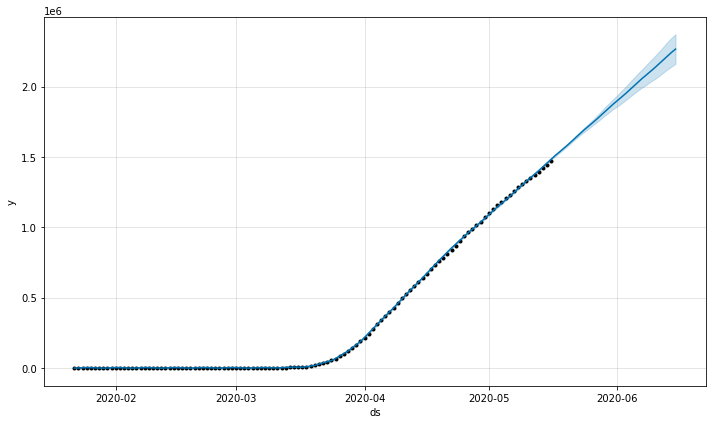

In [34]:
pd.plotting.register_matplotlib_converters()
fig1 = m.plot(forecast)